# Midterm Prep

In [1]:
import pandas as pd
import numpy as np 

trails = pd.read_csv("C:/Users/hblin/OneDrive - Cal Poly/GSB 544/Week 5/national_park_trails.csv")

# 1.1

In [2]:
ca = trails[trails['state_name'] == 'California']

# 1.2 

In [3]:
# Correct assignment
ca['ez_trail'] = False  # Initialize the entire column as False

# Use .loc to set True for rows that meet the conditions
ca.loc[(ca['elevation_gain'] < 500) & (ca['length'] < 5000) & (ca['difficulty_rating'] < 4), 'ez_trail'] = True

ez_trail = ca.loc[(ca['elevation_gain'] < 500) & (ca['length'] < 5000) & (ca['difficulty_rating'] < 4), 'ez_trail']


C:\Users\hblin\AppData\Local\Temp\ipykernel_11072\2604277542.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ca['ez_trail'] = False  # Initialize the entire column as False


In [4]:
ez_trail = ca[(ca['elevation_gain'] < 500) & 
                  (ca['length'] < 5000) & 
                  (ca['difficulty_rating'] < 4)]

#ez_trail.sort_values(by = 'avg_rating', ascending=False)

ez_trail[['area_name', 'avg_rating']].groupby('area_name').mean()

,avg_rating
area_name,
Channel Islands National Park,3.375000
Death Valley National Park,3.711538
Joshua Tree National Park,3.857143
Kings Canyon National Park,4.444444
Lassen Volcanic National Park,4.131579
Pinnacles National Park,4.250000
Redwood National Park,3.642857
Sequoia National Park,4.388889
Yosemite National Park,4.403226


# 1.3 

In [5]:
import re
def find_land(text):
    return re.findall("[Ll]and", str(text))

trails["land_present"] = trails["area_name"].apply(lambda x: find_land(x))


In [6]:
trails['land_present'] = trails['land_present'].astype(bool)
sum(trails['land_present'])


109

# 1.4

In [7]:
np_trails_new = trails[["avg_rating", "difficulty_rating", "visitor_usage", "popularity"]]

np_trails_new_long = pd.melt(np_trails_new, 
                             var_name='measure', 
                             value_name='score')

c:\Users\hblin\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotnine\layer.py:284: PlotnineWarning: stat_density : Removed 253 rows containing non-finite values.


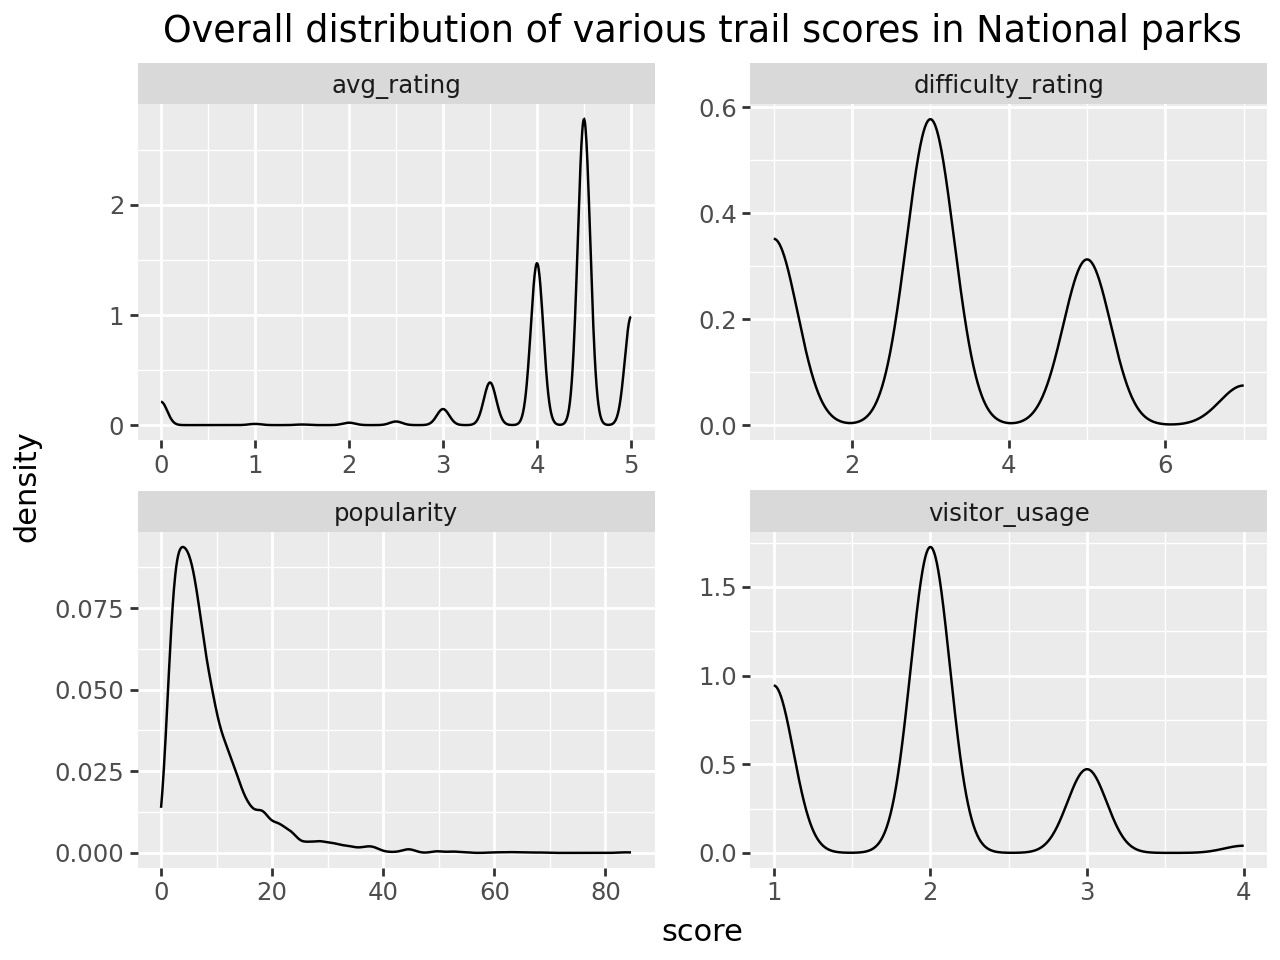

In [8]:
from plotnine import ggplot, aes, geom_density, facet_wrap, ggtitle

(ggplot(np_trails_new_long, aes(x="score"))
+ geom_density()
+ facet_wrap('~ measure', scales = 'free') 
+ ggtitle("Overall distribution of various trail scores in National parks")
)

# 1.5

c:\Users\hblin\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotnine\scales\scale_continuous.py:221: RuntimeWarning: divide by zero encountered in log10
c:\Users\hblin\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
c:\Users\hblin\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotnine\layer.py:284: PlotnineWarning: stat_boxplot : Removed 55 rows containing non-finite values.


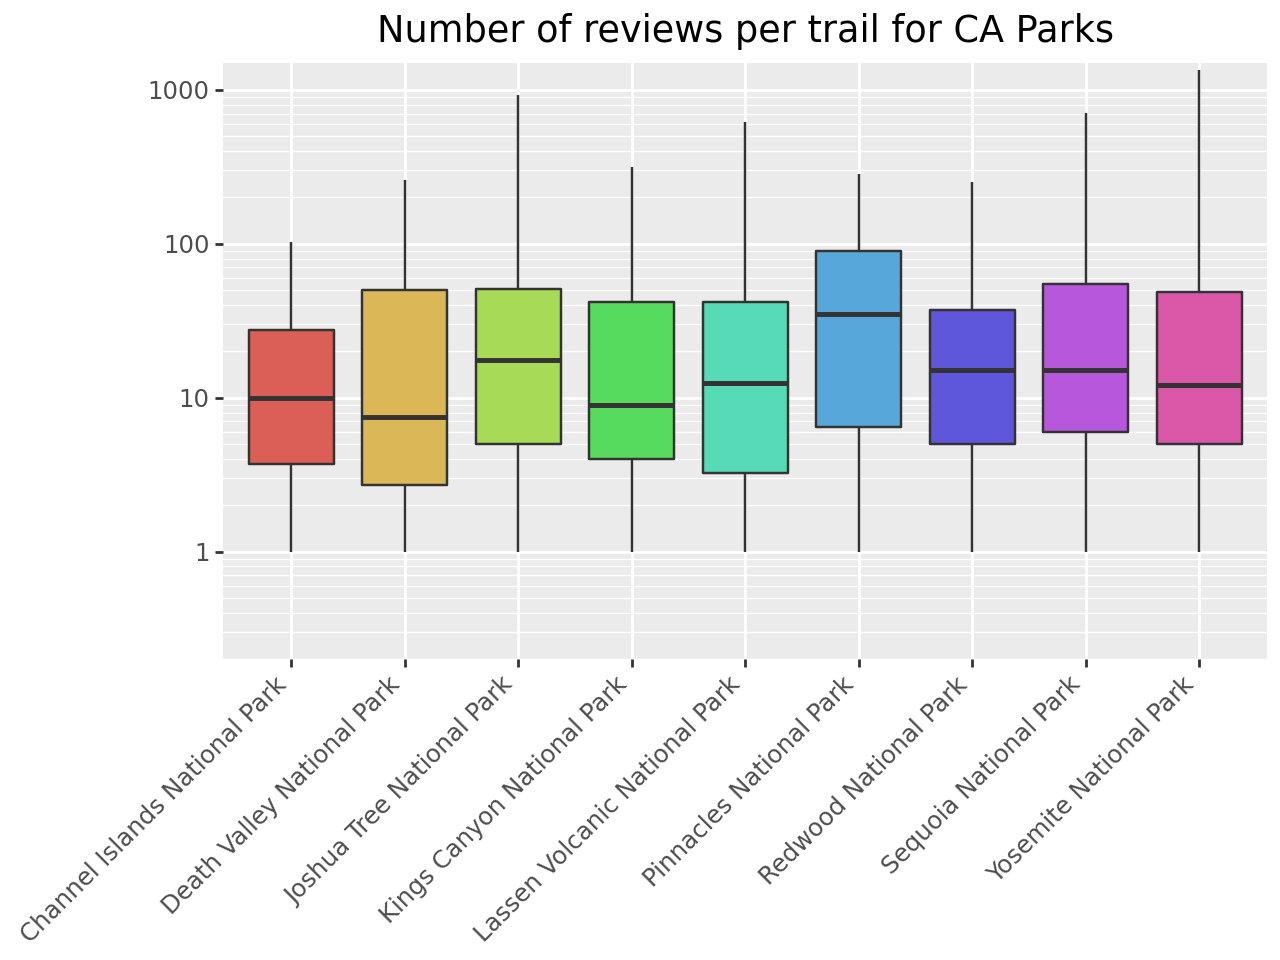

In [9]:
from plotnine import *
from plotnine.scales import *

(ggplot(ca, aes(x="area_name", y="num_reviews", fill = "area_name"))
+ geom_boxplot()
+ scale_y_log10(breaks = [1, 10, 100, 1000], limits =(0, 1500))
+ scale_fill_discrete(guide=None)
+ labs(
  x = "",
  y = "",
  title = "Number of reviews per trail for CA Parks"
)
#+ theme_minimal()
+ theme(axis_text_x = element_text(rotation= 45, hjust=1)) 
)

# 2.1

In [10]:
def recommend_trails(trails, name, min_elev=None, max_elev=None, 
                     min_rating=None, route_type=None):
    # Set default values for optional arguments if not provided
    if min_elev is None:
        min_elev = trails['elevation_gain'].min()
        # if no minimum elevation provided, use the minimum elevation in the dataset
    if max_elev is None:
        max_elev = trails['elevation_gain'].max()
        # if no maximum elevation provided, use the maximum elevation in the dataset
    if min_rating is None:
        min_rating = trails['avg_rating'].min()
        # if no minimum rating provided, use the minimum rating in the dataset
    
    # Filter the dataset based on the criteria
    filtered_trails = trails[
        (trails['area_name'] == name) & # use area name 
        (trails['elevation_gain'] >= min_elev) & # elevation must be at least the min elevation provided
        (trails['elevation_gain'] <= max_elev) & # elevation must be at most the max elevation provided
        (trails['avg_rating'] >= min_rating) # rating must be at least the min rating provided
    ]
    # If a route type is provided, filter the dataset further based on the route type criteria
    if route_type is not None:
        filtered_trails = filtered_trails[filtered_trails['route_type'] == route_type]

    recs = pd.DataFrame(filtered_trails)
    return recs

# Example usage:
#result = recommend_trails(trails, "Pinnacles National Park", min_elev= 500, min_rating=4, route_type = "loop")
#print(result)


In [ ]:
#recommend_trails(trails, "Yosemite National Park", min_elev= 500, min_rating=4, route_type = "loop")

# 2.2

In [12]:
from bs4 import BeautifulSoup
import requests
def scrape_temps(month = None):
  
  base_url = "https://www.extremeweatherwatch.com/us-state-averages"
  month_url = f"{base_url}/month-{month.lower()}" if month else base_url
  response = requests.get(month_url)
  soup = BeautifulSoup(response.text, "html.parser")
  
  rows = []
  for row in soup.find_all("tr"):
    
    # Get all the cells (<td>) in the current row.
    cells = row.find_all("td")

    # Make sure there are enough cells in the row (to avoid IndexError)
    if len(cells) >= 3:
        # Find the name of the state in cell[0], looking for a link (<a>) or just the text in the <td>.
        state_tag = cells[0].find("a") or cells[0]
        state = state_tag.get_text(strip=True)

        # Find the high temp in cell[1]
        high = cells[1].get_text(strip=True)

        # Find the low temp in cell[]
        low = cells[2].get_text(strip=True)

        # Find the land area in cell[2] (make sure you access the right cell index)
        #landarea = cells[5].get_text(strip=True)

        # Append this data to the rows list.
        rows.append({
            "State": state,
            "Month" : month,
            "High Temp": high,
            "Low Temp": low,
        })

    month_weath = pd.DataFrame(rows)

    if month: 
       month_weath.rename(columns = {
          "High Temp": f"High {month.capitalize()} Temperature",
          "Low Temp": f"Low {month.capitalize()} Temperature"
       })
  
  return month_weath

In [ ]:
#scrape_temps(month = 'june')

# 2.3

In [14]:
rec_trails = pd.DataFrame()
for name in ['Yosemite National Park', 'Zion National Park', 'Grand Canyon National Park']:
    rtrails = recommend_trails(trails, name = name,min_elev= 1000, max_elev= 3000, min_rating= 4.5, route_type= 'loop')
    rec_trails = pd.concat([rec_trails, rtrails])

In [15]:
sum_temps = pd.DataFrame()
for month in ['May', 'June', 'July', 'August']:
    month_temps = scrape_temps(month)
    sum_temps = pd.concat([sum_temps, month_temps])

In [16]:
new_temps = sum_temps[sum_temps['State'].isin(['California', 'Utah', 'Arizona'])]


In [26]:
rec_temps = rec_trails.merge(new_temps, left_on='state_name', right_on='State', how='inner', suffixes=('_rec', '_new'))


In [27]:
rec_temps['High Temp'] = rec_temps['High Temp'].astype(float)

rec_temps['Low Temp'] = rec_temps['Low Temp'].astype(float)

In [28]:
rec_temps['hi_peak_temp'] = rec_temps.apply(
    lambda row: row['High Temp'] - (row['elevation_gain']/ 1000) * 5.4, axis = 1)

In [29]:
rec_temps['low_peak_temp'] = rec_temps.apply(
    lambda row: row['Low Temp'] - (row['elevation_gain']/ 1000) * 5.4, axis = 1)